# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [208]:
#Develop a predictive model for the used car dealership that can accurately estimate car prices based 
#on a set of car attributes (manufacturer, model, odometer, condition, Year, title_status,fuel_type,transmission_type) 
#and  environment conditions (region).The goal is to deliver a solution that assists businesses in pricing cars optimally. 
#the data task involves 
# collect the data, 
# check the data type and convert to appropriate datatype 
# check for missing and incomplete and fill null values 
# clean the data 
# normalize or scaling of data (like for the mileage,year of manufacture)
# Train model (can use LinearRegression , Lasso and Ridge regression)
# Compute the model errors for each model  and compare the errors.


In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.linear_model import Lasso

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [210]:

#Read the data given
usedcars = pd.read_csv("C:\\Users\\H468030\\Downloads\\practical_application_II_starter\\data\\vehicles.csv")

usedcars.head()
usedcars.info()

for n, dataset in enumerate([usedcars]):
    prompt = 'usedcars'
    print('\n'+(f' Information Attribute of {prompt} DataSet ').center(151,'='))
    items = [[
        col,
        dataset[col].dtype,
        dataset[col].nunique(),
        list(dataset[col].unique()),
        dataset[col].isnull().sum()
    ] for col in dataset]

    pd.set_option('display.max_colwidth',100)
    display(pd.DataFrame(
        data=items,
        columns=[
            'Attributes',
            'Data Type',
            'Total Unique',
            'Unique Sample',
            'Total Missing'
        ]))
#Inital evaluation of data shows 
#There are 17 columns out of which columns Id, VIN serves for identification of the Car and doesnt contribute to the price of the car. 
usedcars.drop(["id","VIN"],axis=1, inplace=True)

#use the Qusrtile method to identify the outliers
q1,q3=(usedcars['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
usedcars=usedcars[(usedcars.price>=o1) & (usedcars.price<=o2)]

usedcars['odometer'] = usedcars['odometer'].astype('Int64')
usedcars['year'] = usedcars['year'].astype('Int64')
#exponential odometer are considered as outliers and hence selecting the odometer values less than 6 digits only 
#usedcars = usedcars[usedcars['odometer'] <= 999999] 

q1,q3=(usedcars['odometer'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
usedcars=usedcars[(usedcars.odometer>=o1) & (usedcars.odometer<=o2)]

#Categorical values : 
#Condition, Cylinders,fuel,transmission, drive(feature Engineering),titleStatus (unknown)

#Visualisation of Data 

usedcars.info()
usedcars.head(5)






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,Attributes,Data Type,Total Unique,Unique Sample,Total Missing
0,id,int64,426880,"[7222695916, 7218891961, 7221797935, 7222270760, 7210384030, 7222379453, 7221952215, 7220195662,...",0
1,region,object,404,"[prescott, fayetteville, florida keys, worcester / central MA, greensboro, hudson valley, medfor...",0
2,price,int64,15655,"[6000, 11900, 21000, 1500, 4900, 1600, 1000, 15995, 5000, 3000, 0, 13995, 24999, 21850, 26850, 1...",0
3,year,float64,114,"[nan, 2014.0, 2010.0, 2020.0, 2017.0, 2013.0, 2012.0, 2016.0, 2019.0, 2011.0, 1992.0, 2018.0, 20...",1205
4,manufacturer,object,42,"[nan, gmc, chevrolet, toyota, ford, jeep, nissan, ram, mazda, cadillac, honda, dodge, lexus, jag...",17646
5,model,object,29649,"[nan, sierra 1500 crew cab slt, silverado 1500, silverado 1500 crew, tundra double cab sr, f-150...",5277
6,condition,object,6,"[nan, good, excellent, fair, like new, new, salvage]",174104
7,cylinders,object,8,"[nan, 8 cylinders, 6 cylinders, 4 cylinders, 5 cylinders, other, 3 cylinders, 10 cylinders, 12 c...",177678
8,fuel,object,5,"[nan, gas, other, diesel, hybrid, electric]",3013
9,odometer,float64,104870,"[nan, 57923.0, 71229.0, 19160.0, 41124.0, 128000.0, 68696.0, 29499.0, 43000.0, 17302.0, 30237.0,...",4400


<class 'pandas.core.frame.DataFrame'>
Index: 410151 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        410151 non-null  object
 1   price         410151 non-null  int64 
 2   year          409208 non-null  Int64 
 3   manufacturer  394502 non-null  object
 4   model         405470 non-null  object
 5   condition     245313 non-null  object
 6   cylinders     240910 non-null  object
 7   fuel          407832 non-null  object
 8   odometer      410151 non-null  Int64 
 9   title_status  402770 non-null  object
 10  transmission  408552 non-null  object
 11  drive         284693 non-null  object
 12  size          116691 non-null  object
 13  type          321828 non-null  object
 14  paint_color   286058 non-null  object
 15  state         410151 non-null  object
dtypes: Int64(2), int64(1), object(13)
memory usage: 54.0+ MB


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,NaN,NaN,pickup,white,al
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,NaN,NaN,pickup,blue,al
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,NaN,NaN,pickup,red,al
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,NaN,NaN,pickup,red,al
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,full-size,truck,black,al


Text(0, 0.5, 'No. of cars')

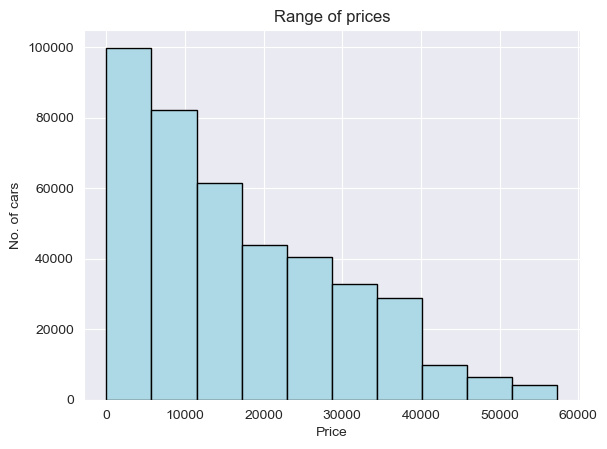

In [211]:
plt.hist(usedcars['price'], color = 'lightblue', edgecolor = 'black',bins=10)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
# Add labels
plt.title('Range of prices')
plt.xlabel('Price')
plt.ylabel('No. of cars')

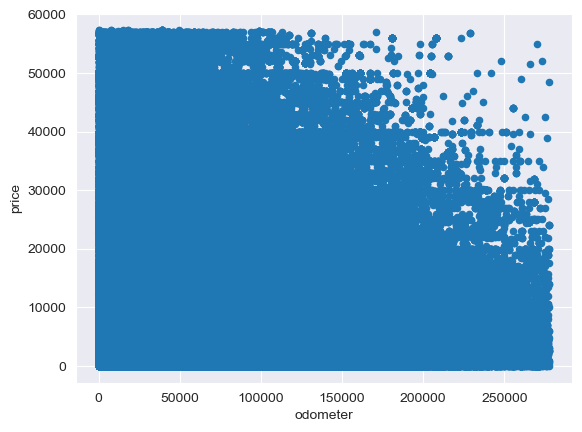

In [212]:
usedcars.plot(x="odometer", y = "price", kind = "scatter");


<Axes: xlabel='fuel', ylabel='count'>

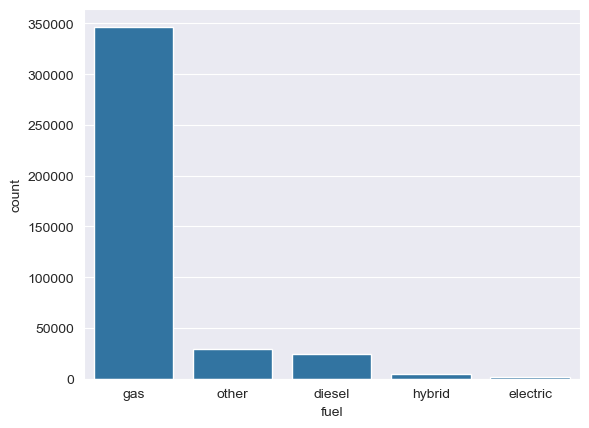

In [213]:
# A categorical feature
sns.countplot(data=usedcars, x='fuel')

<Axes: xlabel='transmission', ylabel='count'>

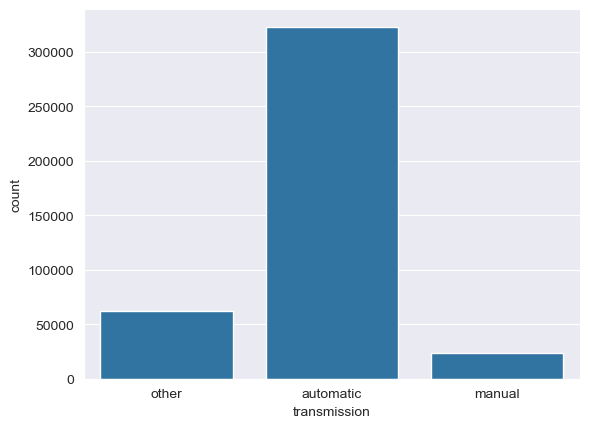

In [214]:
# A categorical feature
sns.countplot(data=usedcars, x='transmission')

<Axes: xlabel='condition', ylabel='count'>

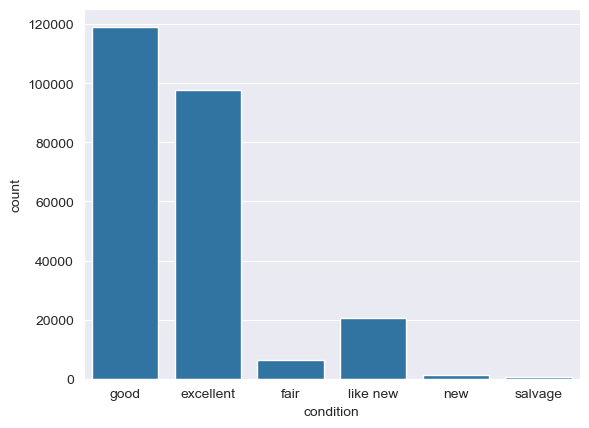

In [215]:
# A categorical feature
sns.countplot(data=usedcars, x='condition')

<Axes: xlabel='cylinders', ylabel='count'>

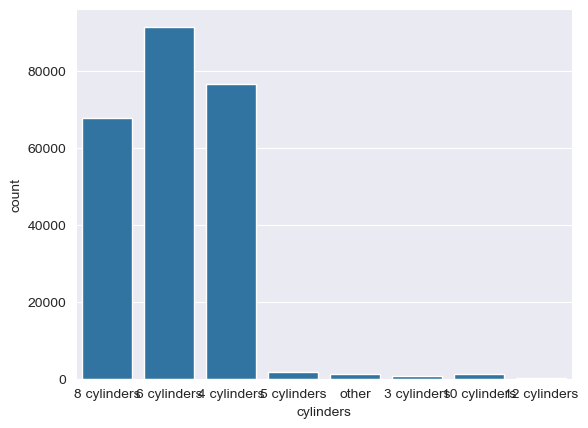

In [216]:
# A categorical feature
sns.countplot(data=usedcars, x='cylinders')

<Axes: xlabel='title_status', ylabel='count'>

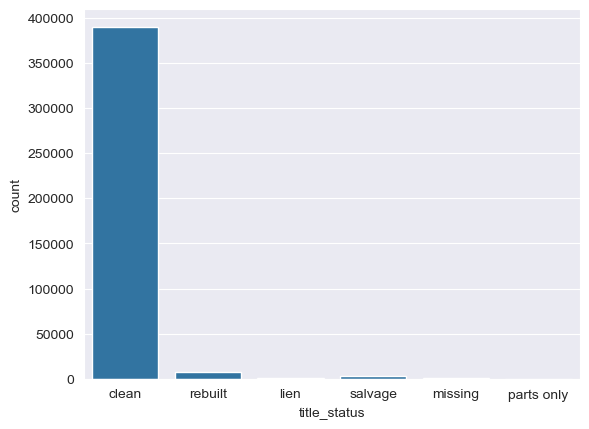

In [217]:
# A categorical feature
sns.countplot(data=usedcars, x='title_status')

<Axes: xlabel='paint_color', ylabel='count'>

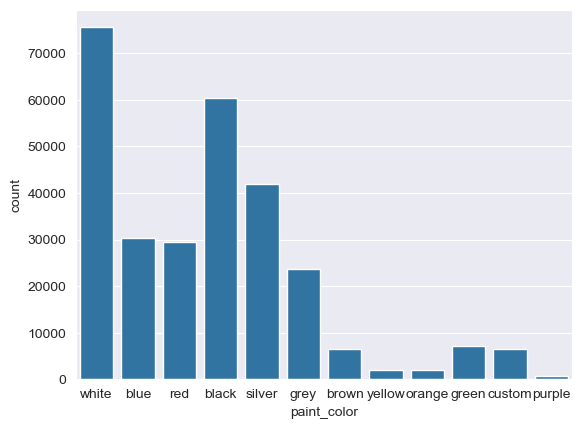

In [218]:
# A categorical feature
sns.countplot(data=usedcars, x='paint_color')

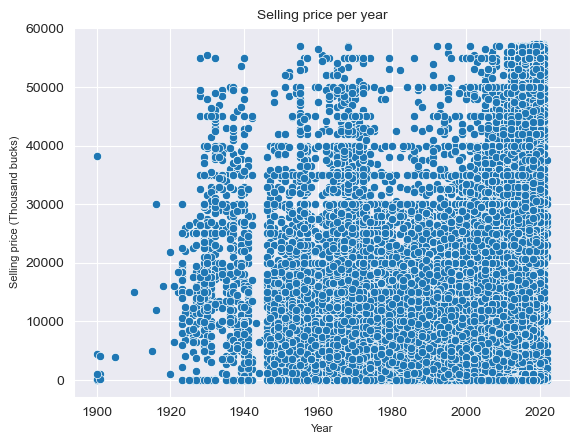

In [219]:
# plotting the target-year scatter graph
sns.scatterplot(data=usedcars, x="year", y="price")
sns.set_style('darkgrid')
plt.title("Selling price per year", size=10)
plt.ylabel("Selling price (Thousand bucks)", size=8)
plt.xlabel("Year", size=8)
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [220]:
# The size seems to have lot of null values and can be concatenated with the type to give meaningful predictions
usedcars['type'] =  usedcars['size'].fillna('') + ' ' + usedcars['type'].fillna('other')

#data imputation with fixed values
usedcars['condition'] = usedcars['condition'].fillna('Unknown')
usedcars['model'] = usedcars['model'].fillna('Unknown')
usedcars['manufacturer'] = usedcars['manufacturer'].fillna('Unknown')
usedcars['cylinders'] = usedcars['cylinders'].fillna('other')
usedcars['fuel'] = usedcars['fuel'].fillna('other')
usedcars['title_status'] = usedcars['title_status'].fillna('Unknown')
usedcars['transmission'] = usedcars['transmission'].fillna('other')
usedcars['drive'] = usedcars['drive'].fillna('Unknown')
usedcars['paint_color'] = usedcars['paint_color'].fillna('other')

In [221]:
#drop size column after concatenation . 
# drop state column as there is a region column already
usedcars.drop(["size","state"],axis=1, inplace=True)
usedcars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410151 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        410151 non-null  object
 1   price         410151 non-null  int64 
 2   year          409208 non-null  Int64 
 3   manufacturer  410151 non-null  object
 4   model         410151 non-null  object
 5   condition     410151 non-null  object
 6   cylinders     410151 non-null  object
 7   fuel          410151 non-null  object
 8   odometer      410151 non-null  Int64 
 9   title_status  410151 non-null  object
 10  transmission  410151 non-null  object
 11  drive         410151 non-null  object
 12  type          410151 non-null  object
 13  paint_color   410151 non-null  object
dtypes: Int64(2), int64(1), object(11)
memory usage: 47.7+ MB


In [222]:
#null values in the Year can be filled using median imputer 
# 2. Using SimpleImputer (Median Imputation)
imputer_median = SimpleImputer(strategy='median')
usedcars['year'] = imputer_median.fit_transform(usedcars[['year']])


In [223]:
def extract_cylinder_count(cylinders):
    cylinder_mapping = {
            '3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5, '6 cylinders': 6, '8 cylinders': 8, '10 cylinders': 10,  '12 cylinders': 12,
        }
    return cylinder_mapping.get(cylinders, np.nan) 
    return np.nan  # Return NaN if no match is found

In [224]:
usedcars['cylinders'] = usedcars['cylinders'].apply(extract_cylinder_count)
# Impute missing cylinder_count values with the mode (most frequent value) of the column

usedcars['cylinders'] = usedcars['cylinders'].fillna(0)



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [251]:
features = ['region','year','model','condition','cylinders','fuel', 'odometer','title_status','transmission','drive','type','paint_color','manufacturer']
cat_columns = ['region','model','condition','fuel', 'title_status','transmission','drive','type','paint_color','manufacturer']
#Convert into numerical values for categorical values 
le = preprocessing.LabelEncoder()
usedcars[cat_columns]=usedcars[cat_columns].apply(le.fit_transform)
numerical_columns = ['region','year','model','condition','cylinders','fuel', 'odometer','title_status','transmission','drive','type','paint_color','manufacturer','price']
scaler = StandardScaler()
usedcars[numerical_columns] = scaler.fit_transform(usedcars[numerical_columns])

X = usedcars.loc[:, features]
y = usedcars.loc[:, ['price']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)





In [263]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)


R2score for Random Forest: 0.3016000974278841
Accuracy for Random Forest: 30.16


In [264]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


R2score for Random Forest: 0.8288333868634359
Accuracy for Random Forest: 82.8833


In [267]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred_lasso=lasso.predict(X_test)


R2score for Lasso: 0.30160165608188505
Accuracy for Lasso: 30.1602


In [268]:
#model object and fitting model
RR=Ridge(alpha=20.336,solver='auto')
RR.fit(X_train,y_train)
y_pred_ridge=RR.predict(X_test)


R2score for Ridge: 0.301600309788447
Accuracy for Ridge: 30.16


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [269]:
print('R2score for Linear Regression:', r2_score(y_test, y_pred_LR))
print('Accuracy for  Linear Regression:', round( r2_score(y_test,y_pred_LR)*100,4))

R2score for Random Forest: 0.3016000974278841
Accuracy for Random Forest: 30.16


In [270]:
print('R2score for Random Forest:', r2_score(y_test, y_pred_rf))
print('Accuracy for Random Forest:', round( r2_score(y_test,y_pred_rf)*100,4))

R2score for Random Forest: 0.8288333868634359
Accuracy for Random Forest: 82.8833


In [271]:
print('R2score for Lasso:', r2_score(y_test, y_pred_lasso))
print('Accuracy for Lasso:', round( r2_score(y_test,y_pred_lasso)*100,4))

R2score for Lasso: 0.30160165608188505
Accuracy for Lasso: 30.1602


In [ ]:
print('R2score for Ridge:', r2_score(y_test, y_pred_ridge))
print('Accuracy for Ridge:', round( r2_score(y_test,y_pred_ridge)*100,4))

In [278]:
data = {'ModelUsed': ['Linear Regression', 'Random Forest', 'Lasso','Ridge'], 'Accuracy': [round( r2_score(y_test,y_pred_LR)*100,4), round( r2_score(y_test,y_pred_rf)*100,4), round( r2_score(y_test,y_pred_lasso)*100,4),round( r2_score(y_test,y_pred_ridge)*100,4)], 'R2Score': [r2_score(y_test, y_pred_LR), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_lasso),r2_score(y_test, y_pred_ridge)]}
models_df = pd.DataFrame(data)
models_df = models_df.sort_values(by='Accuracy')

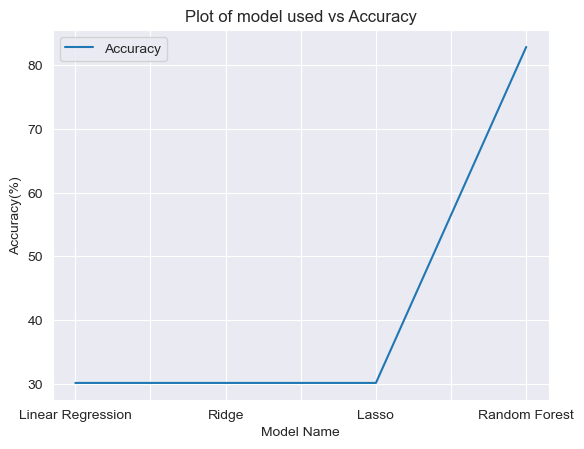

In [279]:
# Plotting two columns
models_df.plot(x='ModelUsed', y='Accuracy')
plt.xlabel('Model Name')
plt.ylabel('Accuracy(%)')
plt.title('Plot of model used vs Accuracy')
plt.show()

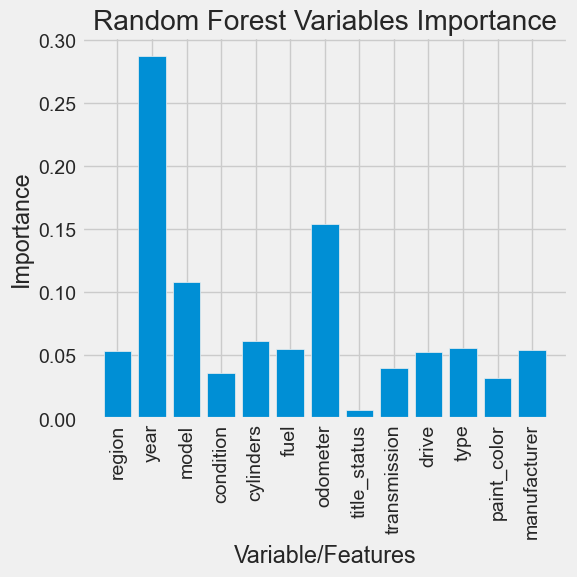

In [285]:
importances=rf.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.show();

In [286]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None]
}
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='accuracy')
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)
# Get the best model from GridSearchCV and make predictions
best_rf_model = grid_search.best_estimator_
y_pred_gs = best_rf_model.predict(X_test)
y_pred_prob_gs = best_rf_model.predict_proba(X_test)[:, 1]  # For ROC-AUC
# Calculate accuracy and ROC-AUC for the best model
accuracy = accuracy_score(y_test, y_pred_gs)
roc_auc = roc_auc_score(y_test, y_pred_prob_gs)
# Cross-validation for accuracy and ROC-AUC
accuracy_scores = grid_search.cv_results_['mean_test_score']
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
roc_auc_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring=make_scorer(roc_auc_score))
mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)
# Display results
print(f"Best Hyperparameters from Grid Search: {grid_search.best_params_}")
print(f"Cross-validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Cross-validation ROC-AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")


KeyboardInterrupt: 

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
#Objective of this exercise is to identify and analyze the key factors contributing to the price of a used car and help the dealer set competitive prices based on the historical data 

In [ ]:
# Findings:  Upon analysis , the title status,Condition, Model, Region, odometer and year contributes to the price of car compared to other parameters.

In [ ]:
# The findings are based on data exploration - identifying missing and inconsistent values , outliers, pricing patterns based on each column/factors etc.  

In [ ]:

# Each model is evaluated using the R2 score and accuracy metrics and Random forest seems to have shown the better metrics compared to other models experimented. 

In [ ]:
#Conclusion: The used car price prediction model can be optimized or fine tuned with Hyper parameters to get better accuracy and can be integrated into the platform. 
#The model is expected to provide users with accurate price estimates, thereby enhancing their buying and selling experience in the used car market

In [ ]:
r, 